In [17]:
import torch
import pandas as pd
import numpy as np

# Import dataset utils
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from pytorch_lightning.trainer import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import LightningModule


import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import importlib
if importlib.util.find_spec('ipywidgets') is not None:
    from tqdm.auto import tqdm
else:
    from tqdm import tqdm

In [18]:
dataframe = pd.read_csv('../data/df_suicidio_ansiedade_ability.csv', sep=',')
dataframe.head()

,Unnamed: 0,Chave,Alcoolatra,Droga,Suic_familia,Dep_familia,Alc_familia,Drog_familia,Neuro,psiquiatrica,...,TOC,Pontuação total,idade,Deprimido,sexo,Estado_civil,Tipo_Resid,Anos educacao formal,ability_suicidio,ability_suicidio_ansiedade
0,0,NDAR_INVLE566FK2,0,0,0,1,1,1,1,1,...,3,25,40,2,0,3,3,12,0.836013,1.173058
1,1,NDAR_INVMA818VXP,0,0,0,1,1,0,0,0,...,0,24,20,3,1,1,4,18,-0.028962,0.128593
2,2,NDAR_INVHY103MHY,0,0,1,1,0,1,0,0,...,0,19,20,2,1,1,1,12,-0.266992,0.090558
3,3,NDAR_INVEC849VWE,0,0,0,1,1,0,0,0,...,6,33,30,2,1,1,1,14,0.380615,0.847915
4,4,NDAR_INVHF792VJY,1,0,0,1,1,0,0,1,...,0,27,40,3,1,4,1,10,-0.171591,0.121865


In [19]:
sorted(dataframe.columns)

['Agitação',
 'Alc_familia',
 'Alcoolatra',
 'Anos educacao formal',
 'Ansiedade',
 'Ansiedade somática',
 'Apetite',
 'Capaz de desfrutar das coisas',
 'Capaz de tomar decisões importantes',
 'Chave',
 'Dep_familia',
 'Deprimido',
 'Drog_familia',
 'Droga',
 'Energia',
 'Estado_civil',
 'Estudante',
 'Hipocondriase',
 'Impacto de sua familia e amigos',
 'Insonia',
 'Lentidao pensamento e fala',
 'Libido',
 'Neuro',
 'Perda de insights',
 'Perda de peso',
 'Pontuação total',
 'Sentimentos_culpa',
 'Suic_familia',
 'Suicidio',
 'TOC',
 'Tipo_Resid',
 'Trabalho e interesses',
 'Unnamed: 0',
 'ability_suicidio',
 'ability_suicidio_ansiedade',
 'idade',
 'psiquiatrica',
 'sexo']

In [68]:
# selected = ['Suicidio', 'Trabalho e interesses', 'Apetite', 'Sentimentos_culpa', 'Perda de insights',
#             'Ansiedade somática', 'Ansiedade', 'Perda de peso', 'Lentidao pensamento e fala',
#             'Hipocondriase', 'Energia', 'Libido',  'sexo','Pontuação total', 'Deprimido']

# selected = ['Suicidio', 'Trabalho e interesses', 'Apetite', 'Sentimentos_culpa', 'Perda de insights',
#             'Ansiedade somática', 'Ansiedade', 'Perda de peso', 'Lentidao pensamento e fala',
#             'Hipocondriase', 'Energia', 'Libido',  'sexo', 'Deprimido']


# selected = ['Suicidio','sexo', 'Estado_civil', 'Tipo_Resid','idade',
#                    'Alcoolatra', 'Droga', 'Suic_familia', 'Dep_familia',
#                    'Alc_familia', 'Drog_familia',
#                    'Neuro',
#                    'psiquiatrica', 'Anos educacao formal', 'Capaz de desfrutar das coisas',
#                    'Impacto de sua familia e amigos',
#                    'Capaz de tomar decisões importantes', 'Estudante',
#                    'Insonia',
#                    'Deprimido', 'Ansiedade',
#                    'Perda de insights', 'Apetite', 'Perda de peso', 'Ansiedade somática',
#                    'Hipocondriase', 'Sentimentos_culpa', 
#                    'Trabalho e interesses', 'Energia', 'Lentidao pensamento e fala',
#                    'Agitação', 'Libido', 'TOC']


selected = [
    "Suic_familia",
    "Drog_familia",
    "Capaz de tomar decisões importantes",
    "Estudante",
    "Hipocondriase",
    "Sentimentos_culpa",
    "Trabalho e interesses",
    "Energia",

    # "idade",
    # "Alc_familia",
    # "Agitação",
    # "Capaz de desfrutar das coisas",

    "Suicidio",
    "Ansiedade",
   
]

dataframe['sexo'].replace({'M': 0, 'F': 1}, inplace=True)
# drop sexo nan
dataframe.dropna(subset=['sexo'], inplace=True)
# dataframe['sexo'].fillna(0, inplace=True) # Talvez jogar fora

df_suic = dataframe[selected]

df_suic = df_suic.dropna()

df_suic = df_suic.astype(float)

# Suicidio < 2 -> 0
# Suicidio >= 2 -> 1
# df_suic['Suicidio'] = df_suic['Suicidio'].apply(lambda x: 0 if x < 2 else 1)

# # Normalize each column
# for col in selected:
#     if col != 'Suicidio' and col != 'Ansiedade':
#         df_suic[col] = (df_suic[col] - df_suic[col].mean()) / df_suic[col].std()
#         # df_suic[col] = df_suic[col] / df_suic[col].max()

df_suic.dropna(inplace=True)
df_suic.shape



(3612, 10)

In [21]:
class MyDataset(Dataset):
 
  def __init__(self, input_dataframe, split="train", target=["Suicidio", "Ansiedade"], ignore_columns=[], train_ratio=0.8):
    
    self.split = split
    self.target = target
    self.ignore_columns = ignore_columns

    for coll in self.ignore_columns:
       if coll in input_dataframe.columns:
        input_dataframe = input_dataframe.drop(coll, axis=1)

    # self.classification_dim = len(input_dataframe[self.target].unique())
    self.data_dim = len(input_dataframe.columns) - len(target) - len(ignore_columns)
    self.embbeding_dim = input_dataframe.max().max() + 1

    y = input_dataframe[target].values
    x = input_dataframe.drop(target, axis = 1).values

    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, test_size=1-train_ratio, random_state=42)

  def __len__(self):
    if self.split == "train":
      return len(self.x_train)
    elif self.split == "test":
      return len(self.x_test)
    else:
      raise ValueError("Split must be train or test")

  def get_weights(self):
    if self.split == "train":
      y = self.y_train
    elif self.split == "test":
      y = self.y_test

    weights = []
    for i in range(len(self.target)):
      weights_dict = pd.DataFrame(y[:,i]).value_counts(normalize=True).to_dict()
      keys = sorted([k for k in weights_dict.keys()], key=lambda x: x[0])
      weights.append(np.array([1/weights_dict[k] for k in keys]))
    self.weights = np.hstack(weights).T

    return self.weights

  def __getitem__(self,idx):
    # target = torch.zeros(self.classification_dim)

    if self.split == "train":
      # target[self.y_train[idx]] = 1
      target = torch.tensor(self.y_train[idx], dtype=torch.float)
      return (torch.tensor(self.x_train[idx], dtype=torch.float), target)
    elif self.split == "test":
      # target[self.y_test[idx]] = 1
      target = torch.tensor(self.y_test[idx], dtype=torch.float)
      return (torch.tensor(self.x_test[idx], dtype=torch.float), target)
    else:
      raise ValueError("Split must be train or test")


In [23]:
## Define a MLP model with N layers

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, n_layers=2):
        super(MLP, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
    
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(self.input_dim, self.hidden_dim))
        for i in range(self.n_layers - 1):
            self.layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
            # self.layers.append(nn.Dropout(0.2))
            # self.layers.append(nn.BatchNorm1d(self.hidden_dim))
            # self.layers.append(nn.ReLU())
            self.layers.append(nn.LeakyReLU())
            # self.layers.append(nn.Tanh())

        self.layers.append(nn.Linear(self.hidden_dim, self.output_dim))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Define a Model with a embbeding layer and a MLP

class RegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, n_layers=2):
        super(RegressionModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # self.embbeding_layer = nn.Embedding(self.embbeding_dim, self.embbeding_out)
        self.mlp = MLP(self.input_dim, self.output_dim, self.hidden_dim, self.n_layers)

    def forward(self, x):
        # x = self.embbeding_layer(x)
        # x = x.view(x.shape[0], -1)
        x = self.mlp(x)
        
        ## classification
        # x = F.softmax(x, dim=1)
        ## regression
        # x = torch.sigmoid(x)

        return x

In [65]:

class BaseModel(LightningModule):
    """A LightningModule organizes your PyTorch code into 6 sections:
        - Computations (init)
        - Validation loop (validation_step)
        - Train loop (training_step)
        - Test loop (test_step)
        - Prediction Loop (predict_step)
        - Optimizers and LR Schedulers (configure_optimizers)
    """

    def __init__(self, input_dim, output_dim, hidden_dim, n_layers, lr=1e-5, loss_weight=None):
        super().__init__()
        self.model = RegressionModel(input_dim, output_dim, hidden_dim=hidden_dim, n_layers=n_layers)
        self.lr = lr

        if loss_weight is not None:
            self.loss_weight = torch.tensor(loss_weight, dtype=torch.float)
        else:
            self.loss_weight = None

        # save hyperparameters
        self.save_hyperparameters()

    def step(self, batch):
        x, y = batch
        y_hat = self.model(x)

        if self.loss_weight is not None:
            loss = F.mse_loss(y_hat, y, reduction="none")
            weight = self.loss_weight[y.long()]
            loss = loss * weight
            loss = loss.mean()
        else:
            # loss = F.mse_loss(y_hat, y)
            loss = F.l1_loss(y_hat, y)

        return loss, y_hat

    def forward(self, x):
        return self.model(x)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self.step(batch)

    def training_step(self, batch, batch_idx):
        loss, y_hat = self.step(batch)
        self.log('overfit/train_loss', loss, )
        # self.log('hp_metric', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, y_hat = self.step(batch)
        self.log('overfit/val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


# Training 

In [66]:


# Initialize callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='overfit/train_loss',
    dirpath='checkpoints/',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min',
)

early_stopping = EarlyStopping(
    monitor='overfit/train_loss',
    min_delta=0.05,
    patience=100,
    verbose=False,
    mode='min'
)


callbacks = [checkpoint_callback, early_stopping]
# callbacks = []

targets = ["Ansiedade"]
batch_size = 128

train_dataset = MyDataset(df_suic, split="train", target=targets, ignore_columns=[], train_ratio=0.9)
test_dataset = MyDataset(df_suic, split="test", target=targets, ignore_columns=[], train_ratio=0.9)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Train dataset size: ", len(train_dataset))
print("Test dataset size: ", len(test_dataset))
print("Train loader size: ", len(train_loader))
print("Test loader size: ", len(test_loader))


weights = train_dataset.get_weights()
# weights = None

# Initialize model
model = BaseModel(input_dim=train_dataset.data_dim, output_dim=len(targets), hidden_dim=512, n_layers=6, lr=1e-4, loss_weight=weights)
# print(model)

# Initialize a trainer
trainer = Trainer(accelerator='cpu', callbacks=callbacks, auto_lr_find=True, enable_progress_bar=False, max_steps=50000)
# trainer.tune(model, train_loader)

# Train the model ⚡
trainer.fit(model, train_loader, test_loader)

Train dataset size:  3250
Test dataset size:  362
Train loader size:  26
Test loader size:  3


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cadar/miniconda3/envs/causal/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/cadar/miniconda3/envs/causal/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /Users/cadar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Github/mental-health/notebooks/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type            | Params
------------------------------------------
0 | model | RegressionModel | 1.3 M 
------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total para

# Looking at the result

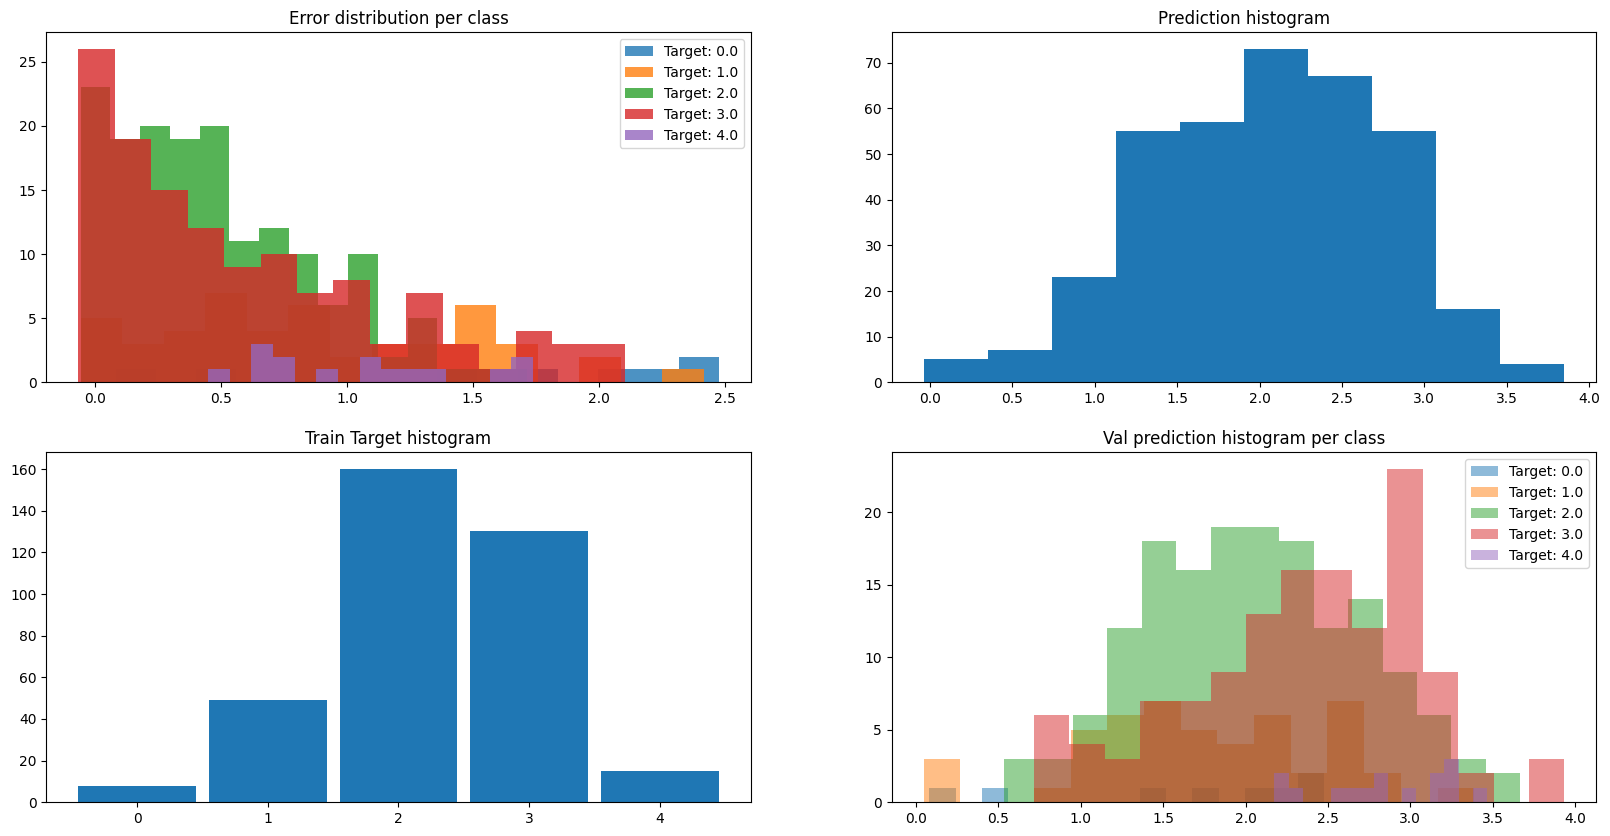

In [70]:
# Plot per class error
import matplotlib.pyplot as plt

# Load model checkpoint
model = BaseModel.load_from_checkpoint(checkpoint_callback.best_model_path)

# Get the targets
targets = []
results = []

# Get the predictions
preds = trainer.predict(model, test_loader)

for batch_idx, batch in enumerate(test_loader):
    targets.append(batch[1].detach().numpy())
    loss, res = preds[batch_idx]
    results.append(res.detach().numpy())

targets = np.concatenate(targets)
results = np.concatenate(results)

plt.figure(figsize=(20, 10))

plt.subplot(221)
for value in np.unique(targets):
    indexes = np.where(targets == value)[0]

    hist = np.histogram(np.abs(results[indexes] - targets[indexes]), bins=15)
    plt.bar(hist[1][:-1], hist[0], width=hist[1][1]-hist[1][0] ,label=f"Target: {value}", alpha=0.8)

plt.title("Error distribution per class")
plt.legend()


# Prodiction histogram
plt.subplot(222)
hist = np.histogram(results, bins=10)
plt.bar(hist[1][:-1], hist[0], width=hist[1][1]-hist[1][0])
plt.title("Prediction histogram")

# Prediction histogram per class
plt.subplot(224)
for value in np.unique(targets):
    indexes = np.where(targets == value)[0]

    hist = np.histogram(results[indexes], bins=15)
    plt.bar(hist[1][:-1], hist[0], width=hist[1][1]-hist[1][0] ,label=f"Target: {value}", alpha=0.5)

plt.title("Val prediction histogram per class")
plt.legend()


# Class histogram
plt.subplot(223)
hist = np.histogram(targets, bins=[0, 1, 2, 3, 4, 5])
plt.bar(hist[1][:-1], hist[0], width=hist[1][1]-hist[1][0] - 0.1, label="Target Suicidio")
plt.title("Train Target histogram")
plt.show()


# Individuality Discovery

In [24]:
class IndividualityNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, n_layers=2, individuality_dim=1):
        super(IndividualityNet, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.indv_net = MLP(input_dim, individuality_dim, hidden_dim, n_layers)
        self.counterfact_net = MLP(input_dim + individuality_dim, output_dim, hidden_dim, n_layers)

    def forward(self, x):
        ind = self.indv_net(x)
        x = torch.cat([x, ind], dim=1)
        x = self.counterfact_net(x)

        return x

    def conterfact(self, individual, modification):
        ind = self.indv_net(individual)
        x = torch.cat([modification, ind], dim=1)
        x = self.counterfact_net(x)

        return x

test_model = IndividualityNet(10, 1, 128, 2, 1)

x = torch.randn(16, 10)
y = test_model(x)

assert y.shape == (16, 1)


In [75]:

class IndividualityModel(LightningModule):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers, individuality_dim=1, lr=1e-3, loss_weight=None):
        super().__init__()
        self.model = IndividualityNet(input_dim, output_dim, hidden_dim=hidden_dim, n_layers=n_layers, individuality_dim=individuality_dim)
        self.lr = lr

        if loss_weight is not None:
            self.loss_weight = torch.tensor(loss_weight, dtype=torch.float)
        else:
            self.loss_weight = None

        # save hyperparameters
        self.save_hyperparameters()

    def step(self, batch):
        x, y = batch
        y_hat = self.model(x)

        if self.loss_weight is not None:
            loss = F.l1_loss(y_hat, y, reduction="none")
            weight = self.loss_weight[y.long()]
            loss = loss * weight
            loss = loss.mean()
        else:
            loss = F.l1_loss(y_hat, y)

        # if loss > 50:
        #     print("Loss: ", loss)
        #     print("y_hat: ", y_hat)
        #     print("y: ", y)
        #     print("x: ", x)
        #     print("------------------")

        return loss, y_hat

    def forward(self, x):
        return self.model(x)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self.step(batch)

    def training_step(self, batch, batch_idx):
        loss, y_hat = self.step(batch)
        self.log('overfit/train_loss', loss, )
        # self.log('hp_metric', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, y_hat = self.step(batch)
        self.log('overfit/val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


In [78]:

# Initialize callbacks
checkpoint_callback2 = ModelCheckpoint(
    monitor='overfit/train_loss',
    dirpath='checkpoints_indv/',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min',
)

early_stopping2 = EarlyStopping(
    monitor='overfit/train_loss',
    min_delta=0.05,
    patience=500,
    verbose=False,
    mode='min'
)

callbacks2 = [checkpoint_callback2, early_stopping2]
# callbacks2 = []

targets = ["Suicidio", "Ansiedade"]
batch_size = 128

train_dataset = MyDataset(df_suic, split="train", target=targets, ignore_columns=[], train_ratio=0.9)
test_dataset = MyDataset(df_suic, split="test", target=targets, ignore_columns=[], train_ratio=0.9)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Train dataset size: ", len(train_dataset))
print("Test dataset size: ", len(test_dataset))
print("Train loader size: ", len(train_loader))
print("Test loader size: ", len(test_loader))

# Initialize model

# weights = train_dataset.get_weights()
weights = None
indv_model = IndividualityModel(input_dim=train_dataset.data_dim, output_dim=len(targets), hidden_dim=512, n_layers=6, individuality_dim=16, lr=1e-4, loss_weight=weights)

# Initialize a trainer
trainer2 = Trainer(accelerator='cpu', callbacks=callbacks2, enable_progress_bar=False, max_steps=30000)
# trainer.tune(model, train_loader)

# Train the model ⚡
trainer2.fit(indv_model, train_loader, test_loader)

Train dataset size:  3250
Test dataset size:  362
Train loader size:  26
Test loader size:  3


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cadar/miniconda3/envs/causal/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/cadar/miniconda3/envs/causal/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /Users/cadar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Github/mental-health/notebooks/checkpoints_indv exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type             | Params
-------------------------------------------
0 | model | IndividualityNet | 2.7 M 
-------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     T

# Running counterfactuals

In [57]:
df_suic.columns

Index(['Suicidio', 'sexo', 'Estado_civil', 'Tipo_Resid', 'idade', 'Alcoolatra',
       'Droga', 'Suic_familia', 'Dep_familia', 'Alc_familia', 'Drog_familia',
       'Neuro', 'psiquiatrica', 'Anos educacao formal',
       'Capaz de desfrutar das coisas', 'Impacto de sua familia e amigos',
       'Capaz de tomar decisões importantes', 'Estudante', 'Insonia',
       'Deprimido', 'Ansiedade', 'Perda de insights', 'Apetite',
       'Perda de peso', 'Ansiedade somática', 'Hipocondriase',
       'Sentimentos_culpa', 'Trabalho e interesses', 'Energia',
       'Lentidao pensamento e fala', 'Agitação', 'Libido', 'TOC'],
      dtype='object')

In [81]:
# Test the model
feature_mod= 'Sentimentos_culpa'

# Choosing individuals that dont drink alcohol
individuals = df_suic[df_suic[feature_mod] == 4].sample(10)

# Showing the individuals target values
targets_values = individuals[targets]
individuals = individuals.drop(columns=targets)
# print("Individuals target values:")
# print(targets_values)

# Choosing modifications
modifications = individuals.copy()
modifications[feature_mod] = 0

# Running counterfactuals
counterfactuals = indv_model.model.conterfact(torch.tensor(individuals.to_numpy()).float(), torch.tensor(modifications.to_numpy()).float()).long().detach().numpy()

# Append to targer_values
counterfactuals = pd.DataFrame(counterfactuals, columns=["New_Suicidio", "New_Ansiedade"], index=individuals.index)
counterfactuals = pd.concat([targets_values, counterfactuals], axis=1)

# Reorder columns
counterfactuals = counterfactuals[["Suicidio", "New_Suicidio", "Ansiedade", "New_Ansiedade"]].astype(int)


# Showing the counterfactuals
print(f"Modifications: {feature_mod} from 4 to 0")
counterfactuals.head(10)


Modifications: Sentimentos_culpa from 4 to 0


,Suicidio,New_Suicidio,Ansiedade,New_Ansiedade
2253,3,0,1,0
2787,1,0,1,1
2449,2,0,0,0
1724,2,1,3,2
2596,2,0,3,2
653,1,1,3,3
2801,3,0,1,1
54,0,0,2,1
2093,2,0,2,2
1444,2,1,2,1


# Graph Discovery

In [ ]:
import causalnex.structure.notears as notears
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
sm = notears.from_pandas(df_suic, max_iter=1000)


ths = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
fig, axs = plt.subplots(2, 3, figsize=(30, 20))
for i, ax in enumerate(axs.flatten()):
    if i > len(ths) - 1:
        # Clean up empty axes
        fig.delaxes(ax)
        continue

    th = ths[i]
    sm.remove_edges_below_threshold(th)

    # Draw only nodes with edges
    sm2 = sm.edge_subgraph(sm.edges)
    labels = {node: node for node in sm2.nodes}
    nx.draw(sm, ax=ax, with_labels=True, nodelist=sm2.nodes, labels=labels, node_size=100, font_size=10)

    # Add rec around ax to make it easier to see
    axis = ax.axis()
    rec = plt.Rectangle((axis[0], axis[2]), (axis[1] - axis[0]), (axis[3] - axis[2]), fill=False, lw=4, linestyle="dotted")
    ax.add_patch(rec)
    ax.set_title(f"Threshold: {th}")



fig.show()